## Instalo bibliotecas - Prophet, Pandas, Joblib, Statsmodels

In [50]:
pip install -r 'requirements.txt'

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Cargo el csv y convierto las fechas a formato YYYY-MM-DD

In [51]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data = pd.read_csv(r'prediccionLipibec.csv', sep=',')

def convert_date(date_string):
  year = int(date_string.split("-")[-1])
  month_dict = {"Ene": 1, "Feb": 2, "Mar": 3, "Abr": 4, "May": 5, "Jun": 6,
                 "Jul": 7, "Ago": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dic": 12}
  month = month_dict[date_string.split("-")[0]]
  return f"{year}-{month:02d}-01"

data.Month = pd.to_datetime(data['Month'].apply(convert_date), format='%Y-%m-%d')


## Grafico los datos

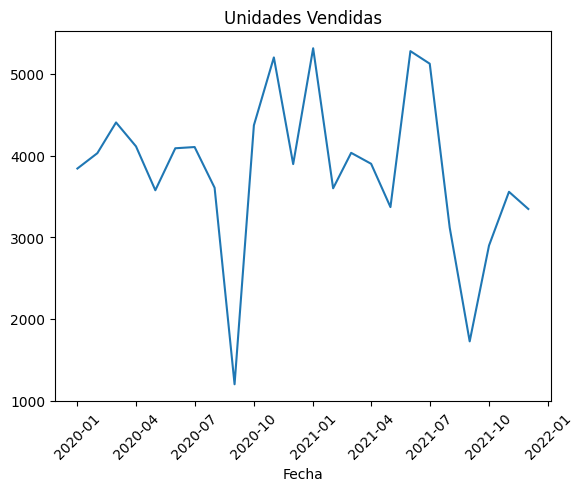

In [52]:
VENTAS = "#Units" 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.xlabel('Fecha')

plt.title("Unidades Vendidas")
plt.xticks(rotation=45)

plt.plot(data.Month, data[VENTAS], )



## Separo el dataset en Train y Test

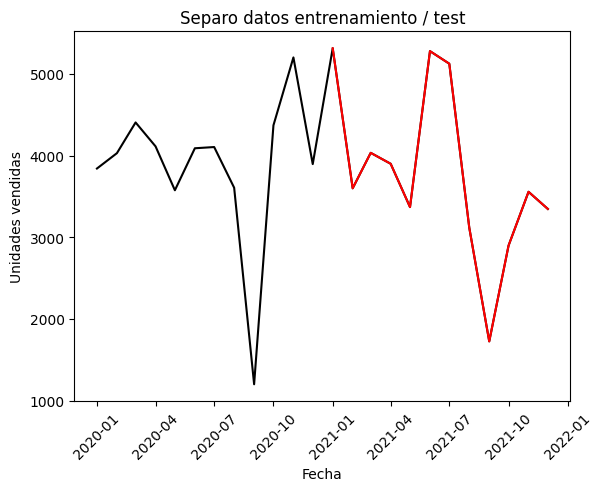

In [53]:
train = data
test = data[data.Month >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')]


plt.plot(train.Month, train[VENTAS], color="black")
plt.plot(test.Month, test[VENTAS], color="red")
plt.ylabel('Unidades vendidas')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.title("Separo datos entrenamiento / test")
plt.show()

## Cambio el nombre de la columna Month por "ds" y Ventas por "y"

In [54]:
df_train_prophet = train

df_train_prophet = df_train_prophet.rename(columns={"Month": "ds" , VENTAS: "y"})


## Corro Prophet con hiperparámetros por defecto

21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
/home/ivan/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ivan/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/tmp/ipykernel_10706/156201147.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

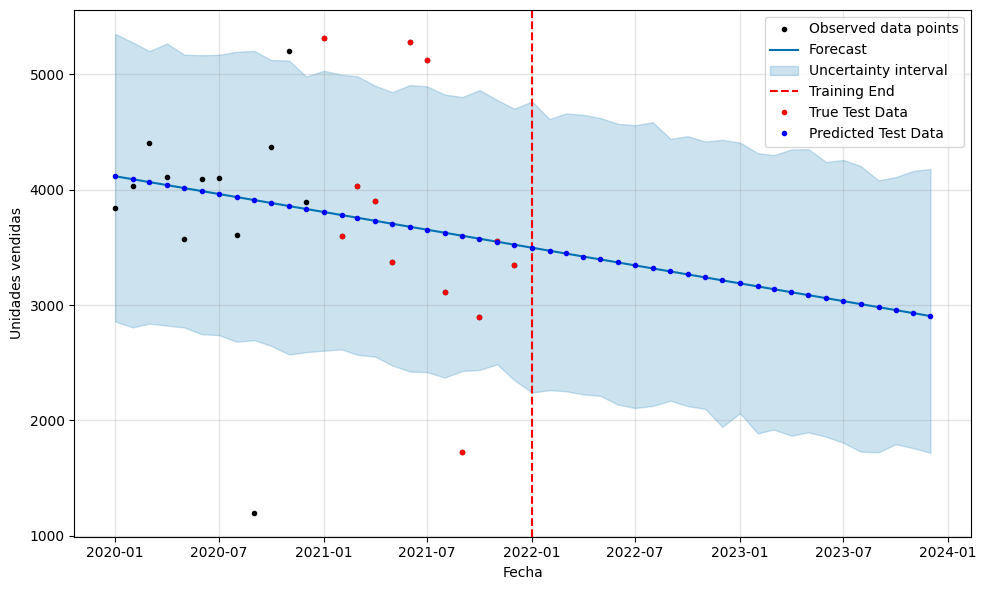

In [55]:
from prophet import Prophet

model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)
df_future = model_prophet.make_future_dataframe(periods=24, freq='MS')

forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

forecast_plot = model_prophet.plot(forecast_prophet)
# agrego una linea vertical al final del periodo de entrenamiento
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-24]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# dibujo los datos de prueba despues de la linea roja
test['Month'] = pd.to_datetime(test['Month'])
plt.plot(test['Month'], test[VENTAS],'ro', markersize=3, label='True Test Data')
plt.plot(df_future, forecast_prophet['yhat'],'bo', markersize=3, label='Predicted Test Data')

plt.ylabel('Unidades vendidas')
plt.xlabel('Fecha')

plt.legend()


## Calculo métricas para los valores de test predecidos

In [56]:
from csv import DictWriter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sktime.performance_metrics.forecasting import *

def metrics(y_true, y_pred, model):
    mae_ = mean_absolute_error(y_true, y_pred) #error absoluto medio
    rmse_ = mean_squared_error(y_true, y_pred, square_root=True) #raíz del error cuadrático medio
    mape_ = mean_absolute_percentage_error(y_true, y_pred) #error absoluto medio porcentual
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric=True) #error absoluto medio porcentual simétrico
    r2_ = r2_score(y_true, y_pred) #coeficiente de determinación

    dict_ = {'MAE': mae_, 'RMSE': rmse_, 'MAPE': mape_, 'SMAPE': smape_, 'R2': r2_}
    metrics_df = pd.DataFrame(dict_, index=[model])
    return (metrics_df.round(decimals=2))

y_true = test[VENTAS][-12:]
y_pred = forecast_prophet['yhat'].iloc[-12:]

metrics(y_true, y_pred, 'prophet')

,MAE,RMSE,MAPE,SMAPE,R2
prophet,943.99,1213.76,0.25,0.26,-0.43


## Busco los mejores hiperparámetros

In [57]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
import itertools

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    param_combinations = []
    for params in param_iter:
        param_combinations.append(params)
    params_df = pd.DataFrame(param_combinations, columns=param_dict.keys())
    return params_df

def train_return_results(params):
    model = Prophet(**params)
    model.fit(df_train_prophet)
    df_future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(df_future)
    return mean_squared_error(test[VENTAS][-12:], forecast['yhat'][-12:])

param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.05, 0.1, 0.5], #flexibilidad de la tendencia, cuánto cambia en los puntos de cambio de tendencia.
    "changepoint_range": [0.8, 0.9, 0.95], #proporción del historial en la que se permite que cambie la tendencia
    "seasonality_prior_scale": [0.1, 1, 10.0], #flexibilidad de la estacionalidad, 
    "holidays_prior_scale": [0.1, 1, 10.0], #flexibilidad para adaptarse a los efectos de los feriados
    "yearly_seasonality": ['auto',True,False] #estacionalidad anual
}

all_params = create_param_combinations(**param_grid)

rmses = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_return_results)(dict(zip(all_params.keys(), param)))
    for param in all_params.values
)

all_params['rmse'] = rmses

best_parameters = dict(all_params.sort_values("rmse").drop("rmse", axis=1).iloc[0])

pd.DataFrame(best_parameters, index=['best_parameters'])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09

,changepoint_prior_scale,changepoint_range,seasonality_prior_scale,holidays_prior_scale,yearly_seasonality
best_parameters,0.001,0.95,1.0,0.1,True


## Corro Prophet nuevamente con los hiperparámetros encontrados

21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing
/home/ivan/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ivan/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/tmp/ipykernel_10706/1701296977.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

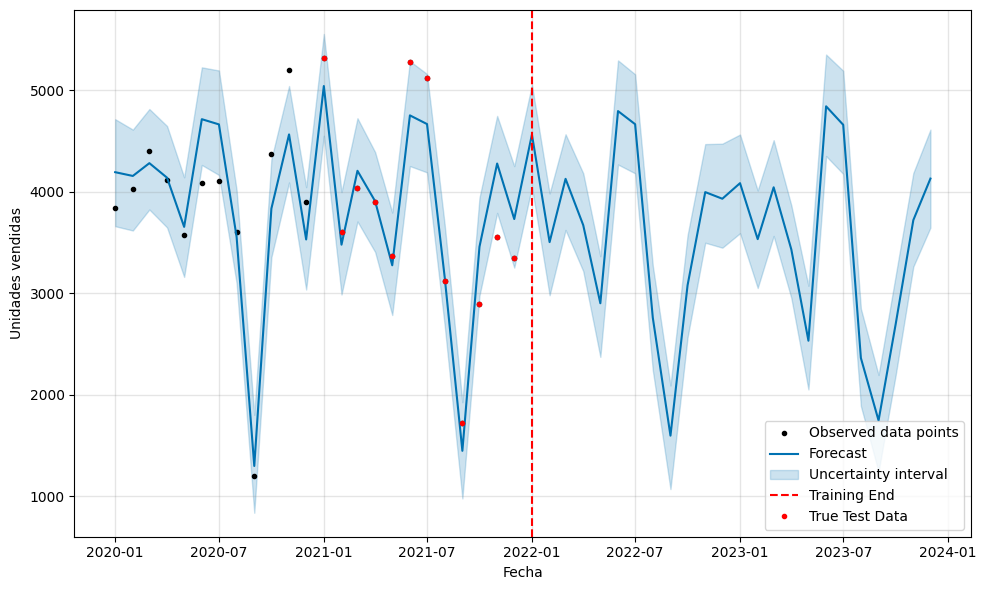

In [58]:
from prophet import Prophet

model_prophet  = Prophet(changepoint_prior_scale=best_parameters['changepoint_prior_scale'],
                         changepoint_range=best_parameters['changepoint_range'],
                         holidays_prior_scale=best_parameters['holidays_prior_scale'],
                         seasonality_prior_scale=best_parameters['seasonality_prior_scale'],
                         yearly_seasonality=best_parameters['yearly_seasonality']
                         )
model_prophet.fit(df_train_prophet)
df_future = model_prophet.make_future_dataframe(periods=24, freq='MS')



forecast_prophet = model_prophet.predict(df_future)


forecast_plot = model_prophet.plot(forecast_prophet, uncertainty=True)

# agrego una linea vertical al final del periodo de entrenamiento
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-24]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# dibujo los datos de prueba despues de la linea roja
test['Month'] = pd.to_datetime(test['Month'])
plt.plot(test['Month'], test[VENTAS],'ro', markersize=3, label='True Test Data')
#plt.plot(df_future, forecast_prophet['yhat'],'bo', markersize=3, label='Predicted Test Data')


plt.ylabel('Unidades vendidas')
plt.xlabel('Fecha')

plt.legend()

## Muestro los valores predecidos para los próximos dos años

In [59]:
pd.DataFrame(forecast_prophet[['ds', 'yhat']][-24:].round())


,ds,yhat
24,2022-01-01,4563.0
25,2022-02-01,3503.0
26,2022-03-01,4127.0
27,2022-04-01,3670.0
28,2022-05-01,2901.0
29,2022-06-01,4794.0
30,2022-07-01,4665.0
31,2022-08-01,2759.0
32,2022-09-01,1597.0
33,2022-10-01,3078.0


## Calculo las nuevas métricas

In [60]:
from csv import DictWriter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sktime.performance_metrics.forecasting import *

def metrics(y_true, y_pred, model):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root=True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric=True)
    r2_ = r2_score(y_true, y_pred)

    dict_ = {'MAE': mae_, 'RMSE': rmse_, 'MAPE': mape_, 'SMAPE': smape_, 'R2': r2_}
    metrics_df = pd.DataFrame(dict_, index=[model])
    return (metrics_df.round(decimals=2))


y_true = test[VENTAS][-12:]
y_pred = forecast_prophet['yhat'][:12]

metrics(y_true, y_pred, 'prophet')

,MAE,RMSE,MAPE,SMAPE,R2
prophet,538.82,618.82,0.15,0.15,0.63
